# Inception Model Training

In [1]:
import glob
import os
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Concatenate, Flatten, Dense

## Load TFRecords data

In [2]:
raw_image_dataset = tf.data.TFRecordDataset(glob.glob('tfrecords/*'))

image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def preprocess(img):
    return tf.image.convert_image_dtype(img, tf.float32)

def _parse_image_label(parsed_dataset):
    return preprocess(tf.image.decode_png(parsed_dataset['image_raw'])), parsed_dataset['label']

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
dataset = parsed_image_dataset.map(_parse_image_label)

## Data Augmentation

In [3]:
def augmentation(img, label):
    def flip(x):
        x = tf.image.random_flip_left_right(x)  # 좌우 확률 0.5
        x = tf.image.random_flip_up_down(x)
        return x
    
    def rotate(x):
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32) > 0.5,
                    lambda: tfa.image.rotate(x,
                                             tf.random.uniform(shape=[], minval=0.0, maxval=360.0, dtype=tf.float32),
                                             interpolation='BILINEAR'),
                    lambda: x)
        return x
    
    def translation(x):
        dx = tf.random.uniform(shape=[], minval=-10.0, maxval=10.0, dtype=tf.float32)
        dy = tf.random.uniform(shape=[], minval=-10.0, maxval=10.0, dtype=tf.float32)
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32) > 0.5,
                    lambda: tfa.image.transform(x,
                                                [0, 0, dx, 0, 0, dy, 0, 0],
                                                interpolation='BILINEAR'),
                    lambda: x)
        return x
    
    img = flip(img)
    img = rotate(img)
    img = translation(img)
           
    return img, label

## Split dataset

In [4]:
ds_size = 0
for _ in dataset:
    ds_size += 1

train_size = int(ds_size * 0.7)
print(train_size)

ds = dataset.shuffle(ds_size)

# data augmentation - flip, rotate, translation
ds_train = ds.take(train_size).shuffle(1024, reshuffle_each_iteration=True).prefetch(1024).batch(32).map(augmentation)
ds_valid = ds.skip(train_size).prefetch(1024).batch(32)

1736


## Define inception-based model

In [5]:
def Model():
    def inception(filters):
        def subnetwork(x):
            # 1x1 filter
            h1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
            h1 = MaxPool2D()(h1)
            
            # 3x3 filter
            h2 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)  # bottle neck layer
            h2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(h2)
            h2 = MaxPool2D()(h2)
            
            # 5x5 filter
            h3 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
            h3 = Conv2D(filters, (5, 5), padding='same', activation='relu')(h3)
            h3 = MaxPool2D()(h3)
            
            return Concatenate()([h1, h2, h3])
        return subnetwork
    
    x = tf.keras.Input(shape=(256, 256, 3))
    h = inception(16)(x)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = Flatten()(h)
    h = Dense(1024, activation='relu')(h)
    y = Dense(1, activation='sigmoid')(h)
    
    return tf.keras.Model(inputs=x, outputs=y)

In [6]:
model = Model()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model.summary()

## Train model

In [7]:
EPOCHS = 500
RESULT_SAVE_PATH = 'results/'

In [8]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)

history = model.fit(ds_train,
                    validation_data=ds_valid,
                    epochs=EPOCHS,
                    callbacks=[earlystopping])

Epoch 1/500
55/55 [==============================] - 24s 444ms/step - loss: 0.6963 - accuracy: 0.4781 - val_loss: 0.7164 - val_accuracy: 0.4812
Epoch 2/500
55/55 [==============================] - 23s 409ms/step - loss: 0.6829 - accuracy: 0.5444 - val_loss: 0.6373 - val_accuracy: 0.7030
Epoch 3/500
55/55 [==============================] - 23s 417ms/step - loss: 0.6908 - accuracy: 0.5115 - val_loss: 0.6808 - val_accuracy: 0.5040
Epoch 4/500
55/55 [==============================] - 23s 414ms/step - loss: 0.6878 - accuracy: 0.4891 - val_loss: 0.6921 - val_accuracy: 0.4839
Epoch 5/500
55/55 [==============================] - 23s 416ms/step - loss: 0.6887 - accuracy: 0.5132 - val_loss: 0.6771 - val_accuracy: 0.5363
Epoch 6/500
55/55 [==============================] - 23s 411ms/step - loss: 0.6876 - accuracy: 0.5334 - val_loss: 0.6398 - val_accuracy: 0.6358
Epoch 7/500
55/55 [==============================] - 23s 421ms/step - loss: 0.6838 - accuracy: 0.5311 - val_loss: 0.6782 - val_accuracy:

55/55 [==============================] - 23s 409ms/step - loss: 0.6202 - accuracy: 0.6359 - val_loss: 0.5329 - val_accuracy: 0.7366
Epoch 58/500
55/55 [==============================] - 22s 403ms/step - loss: 0.6329 - accuracy: 0.6233 - val_loss: 0.5264 - val_accuracy: 0.7621
Epoch 59/500
55/55 [==============================] - 23s 420ms/step - loss: 0.6484 - accuracy: 0.5870 - val_loss: 0.5403 - val_accuracy: 0.7406
Epoch 60/500
55/55 [==============================] - 22s 407ms/step - loss: 0.6263 - accuracy: 0.6169 - val_loss: 0.5258 - val_accuracy: 0.7366
Epoch 61/500
55/55 [==============================] - 22s 397ms/step - loss: 0.6334 - accuracy: 0.6043 - val_loss: 0.4935 - val_accuracy: 0.7500
Epoch 62/500
55/55 [==============================] - 22s 402ms/step - loss: 0.6223 - accuracy: 0.6146 - val_loss: 0.5430 - val_accuracy: 0.7460
Epoch 63/500
55/55 [==============================] - 23s 413ms/step - loss: 0.6365 - accuracy: 0.6129 - val_loss: 0.5198 - val_accuracy: 0.756

55/55 [==============================] - 22s 394ms/step - loss: 0.5964 - accuracy: 0.6175 - val_loss: 0.5626 - val_accuracy: 0.7218
Epoch 114/500
55/55 [==============================] - 22s 401ms/step - loss: 0.6126 - accuracy: 0.6342 - val_loss: 0.4780 - val_accuracy: 0.7769
Epoch 115/500
55/55 [==============================] - 22s 407ms/step - loss: 0.6257 - accuracy: 0.6083 - val_loss: 0.4513 - val_accuracy: 0.7917
Epoch 116/500
55/55 [==============================] - 22s 399ms/step - loss: 0.5663 - accuracy: 0.6578 - val_loss: 0.4820 - val_accuracy: 0.7594
Epoch 117/500
55/55 [==============================] - 22s 407ms/step - loss: 0.5994 - accuracy: 0.6129 - val_loss: 0.4152 - val_accuracy: 0.7984
Epoch 118/500
55/55 [==============================] - 22s 402ms/step - loss: 0.5862 - accuracy: 0.6198 - val_loss: 0.4559 - val_accuracy: 0.7782
Epoch 119/500
55/55 [==============================] - 22s 400ms/step - loss: 0.5588 - accuracy: 0.6555 - val_loss: 0.4063 - val_accuracy:

55/55 [==============================] - 22s 398ms/step - loss: 0.4975 - accuracy: 0.6987 - val_loss: 0.3141 - val_accuracy: 0.8548
Epoch 170/500
55/55 [==============================] - 23s 410ms/step - loss: 0.5299 - accuracy: 0.6584 - val_loss: 0.2922 - val_accuracy: 0.8831
Epoch 171/500
55/55 [==============================] - 22s 400ms/step - loss: 0.5252 - accuracy: 0.6682 - val_loss: 0.3956 - val_accuracy: 0.8401
Epoch 172/500
55/55 [==============================] - 22s 404ms/step - loss: 0.5531 - accuracy: 0.6601 - val_loss: 0.3310 - val_accuracy: 0.8696
Epoch 173/500
55/55 [==============================] - 22s 404ms/step - loss: 0.5244 - accuracy: 0.6590 - val_loss: 0.2843 - val_accuracy: 0.8669
Epoch 174/500
55/55 [==============================] - 23s 412ms/step - loss: 0.5308 - accuracy: 0.6613 - val_loss: 0.2728 - val_accuracy: 0.8898
Epoch 175/500
55/55 [==============================] - 22s 398ms/step - loss: 0.5150 - accuracy: 0.6722 - val_loss: 0.3048 - val_accuracy:

55/55 [==============================] - 22s 405ms/step - loss: 0.4857 - accuracy: 0.7062 - val_loss: 0.1036 - val_accuracy: 0.9651
Epoch 226/500
55/55 [==============================] - 22s 406ms/step - loss: 0.4704 - accuracy: 0.7079 - val_loss: 0.1032 - val_accuracy: 0.9664
Epoch 227/500
55/55 [==============================] - 22s 398ms/step - loss: 0.4465 - accuracy: 0.7154 - val_loss: 0.0776 - val_accuracy: 0.9785
Epoch 228/500
55/55 [==============================] - 22s 394ms/step - loss: 0.3947 - accuracy: 0.7500 - val_loss: 0.0967 - val_accuracy: 0.9651
Epoch 229/500
55/55 [==============================] - 22s 404ms/step - loss: 0.3904 - accuracy: 0.7581 - val_loss: 0.0651 - val_accuracy: 0.9745
Epoch 230/500
55/55 [==============================] - 22s 405ms/step - loss: 0.3859 - accuracy: 0.7592 - val_loss: 0.0662 - val_accuracy: 0.9798
Epoch 231/500
55/55 [==============================] - 22s 400ms/step - loss: 0.4418 - accuracy: 0.6930 - val_loss: 0.0776 - val_accuracy:

55/55 [==============================] - 22s 404ms/step - loss: 0.4521 - accuracy: 0.6907 - val_loss: 0.0449 - val_accuracy: 0.9866
Epoch 282/500
55/55 [==============================] - 22s 405ms/step - loss: 0.3309 - accuracy: 0.7857 - val_loss: 0.0315 - val_accuracy: 0.9933
Epoch 283/500
55/55 [==============================] - 23s 410ms/step - loss: 0.4820 - accuracy: 0.6843 - val_loss: 0.0613 - val_accuracy: 0.9852
Epoch 284/500
55/55 [==============================] - 22s 400ms/step - loss: 0.4088 - accuracy: 0.7304 - val_loss: 0.0691 - val_accuracy: 0.9677
Epoch 285/500
55/55 [==============================] - 22s 404ms/step - loss: 0.4513 - accuracy: 0.6912 - val_loss: 0.0612 - val_accuracy: 0.9785
Epoch 286/500
55/55 [==============================] - 22s 405ms/step - loss: 0.4308 - accuracy: 0.7126 - val_loss: 0.0345 - val_accuracy: 0.9960
Epoch 287/500
55/55 [==============================] - 22s 396ms/step - loss: 0.3957 - accuracy: 0.7477 - val_loss: 0.0526 - val_accuracy:

## Loss plot

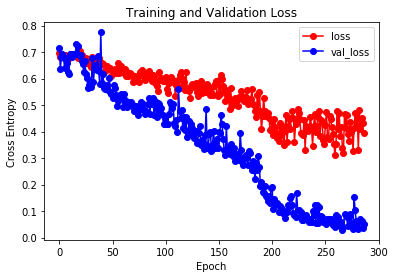

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-', label='loss')
plt.plot(val_loss, 'bo-', label='val_loss')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [10]:
model.save('inception_model.h5')